# Dataset - https://www.kaggle.com/jasmeetkaur/fishdataset

In [29]:
import os
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras import datasets, layers, models, utils


### Let's create: 
> 1) List with fish names.\
> 2) Dictionary where the key is the fish name, and the value is the list with the paths to pictures of this fish.\
> 3) Dictionary where the key is the fish name, and the value is the number of pictures of that fish.

In [30]:
fish_list = os.listdir('FishDataset')
img_paths = {fish : [f'FishDataset/{fish}/' + i for i in os.listdir(f"FishDataset/{fish}")] 
                                                                    for fish in fish_list}
lengths = {fish : len(img_paths[fish]) for fish in fish_list}

### To begin with, let's bring all images to a ratio of 1 to 1 by cutting out the maximum square in the center and to one resolution. Let's write a function for that.

In [31]:
def crop_resize(img):
    width, height = img.size
    if width > height:
        new_width = height
        new_height = height
    else: 
        new_width = width
        new_height = width
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return img.crop((left, top, right, bottom)).resize((100,100))

### Next, apply our function to all images on the dataset, iterating by fish species and by path for each species.

In [32]:
for fish in fish_list:
    for path in img_path[fish]:
        try:
            image = Image.open(path)
            image = crop_resize(image)
            image.save(path)
        except:
            os.remove(path)

### Let's re-create the paths because the images with the wrong format were removed

In [33]:
img_path = {fish : [f'FishDataset/{fish}/' + i for i in os.listdir(f"FishDataset/{fish}")] 
                                                                    for fish in fish_list}
lengths_new = {fish : len(os.listdir(f'FishDataset/{fish}')) for fish in fish_list}

In [34]:
lengths_new

{'ArcticCharFish': 945,
 'Red-snapper': 412,
 'SardineFish': 953,
 'TilapiaFish': 1044,
 'bassfish': 1158,
 'catfish': 521,
 'haddockfish': 857,
 'salmon': 1181,
 'swordfish': 1162,
 'tuna': 1284}

### We equalize the classes so that it would be easier to evaluate the model. That way we can use accuracy metric. The random result in this case will be 10%, because we will have 10 equal classes.

In [35]:
for fish in fish_list:
    img_path[fish] = img_path[fish][:400]

### Each picture is an array of dimensions (100, 100, 1), with elements of type int taking values between 0 and 255 if the image is greyscale. Or with dimensions (100, 100, 3) if the image is color(RGB). We are going to get these arrays for color images  and normalize them by dividing by 255.

In [36]:
pixel_representaion = {}
for fish in fish_list:
    pixel_representations_for_current_fish = []
    for img in img_path[fish]:
        try:
            pixels = np.asarray(Image.open(img).convert('RGB')) / 255.0
            pixel_representations_for_current_fish.append(pixels)
        except:
            continue
    pixel_representaion[fish] = pixel_representations_for_current_fish

In [47]:
pixel_representaion['tuna'][0]

array([[[0.69411765, 0.70588235, 0.90588235],
        [0.71764706, 0.72941176, 0.92941176],
        [0.6627451 , 0.6745098 , 0.88235294],
        ...,
        [0.8627451 , 0.89019608, 0.92156863],
        [0.90196078, 0.92941176, 0.96078431],
        [0.90196078, 0.92941176, 0.96078431]],

       [[0.63137255, 0.64313725, 0.84313725],
        [0.66666667, 0.67843137, 0.87843137],
        [0.63529412, 0.64705882, 0.85490196],
        ...,
        [0.96862745, 0.99215686, 1.        ],
        [0.97254902, 0.99607843, 1.        ],
        [0.96078431, 0.98431373, 1.        ]],

       [[0.57647059, 0.58823529, 0.79607843],
        [0.61960784, 0.63137255, 0.83921569],
        [0.60784314, 0.61960784, 0.82745098],
        ...,
        [0.86666667, 0.88627451, 0.97254902],
        [0.83137255, 0.85098039, 0.9372549 ],
        [0.81176471, 0.83137255, 0.91764706]],

       ...,

       [[0.09019608, 0.14901961, 0.30980392],
        [0.08235294, 0.14117647, 0.29411765],
        [0.07058824, 0

In [48]:
pixel_representaion['tuna'][0].shape

(100, 100, 3)

### Finally, let's move on to filling in the dataset and splitting it into training and test samples.

In [49]:
data = []
for fish in fish_list:
    for img in pixel_representaion[fish]:
        data.append([img, fish])
random.shuffle(data)

X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])


In [50]:
X.shape

(4000, 100, 100, 3)

In [51]:
fish_list_dir = {fish_list[i]: i for i in range(len(fish_list))}
y = np.array([fish_list_dir[i] for i in y])

train_X, train_y = X[:3600], y[:3600]
test_X, test_y = X[3600:], y[3600:]

### We will build a convolutionary neural network for classificate our fishes and train it.

In [53]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
history = model.fit(train_X, train_y, epochs=40, 
                    validation_data=(test_X, test_y))

Train on 3600 samples, validate on 400 samples
Epoch 1/40
3600/3600 [==============================] - 71s 20ms/sample - loss: 2.2916 - accuracy: 0.1189 - val_loss: 2.1852 - val_accuracy: 0.1350
Epoch 2/40
3600/3600 [==============================] - 47s 13ms/sample - loss: 2.1407 - accuracy: 0.2072 - val_loss: 2.0643 - val_accuracy: 0.2375
Epoch 3/40
3600/3600 [==============================] - 52s 15ms/sample - loss: 2.0041 - accuracy: 0.2925 - val_loss: 1.9636 - val_accuracy: 0.2550
Epoch 4/40
3600/3600 [==============================] - 51s 14ms/sample - loss: 1.8349 - accuracy: 0.3592 - val_loss: 1.8535 - val_accuracy: 0.3450
Epoch 5/40
3600/3600 [==============================] - 53s 15ms/sample - loss: 1.6005 - accuracy: 0.4414 - val_loss: 1.8624 - val_accuracy: 0.3925
Epoch 6/40
3600/3600 [==============================] - 53s 15ms/sample - loss: 1.2127 - accuracy: 0.5950 - val_loss: 2.0421 - val_accuracy: 0.3975
Epoch 7/40
3600/3600 [==============================] - 53s 15ms/

In [55]:
def plot_his(key, history):
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows = 1, figsize = (18, 6))
    ax1.plot(range(len(history.history[key])), history.history[key], c='b')
    ax1.set_xlabel('epochs', fontsize=18)
    ax1.set_ylabel(f'train_{key}', fontsize=18)
    ax2.plot(range(len(history.history[f'val_{key}'])), history.history[f'val_{key}'], c='b')
    ax2.set_xlabel('epochs', fontsize=18)
    ax2.set_ylabel(f'test_{key}', fontsize=18)

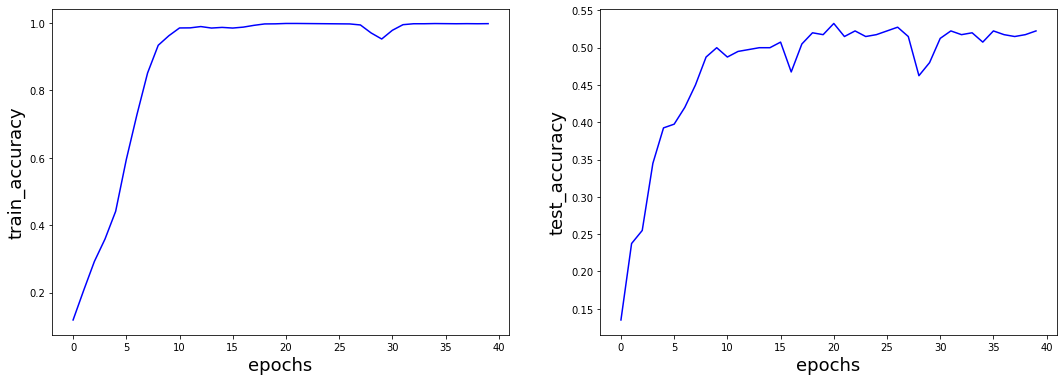

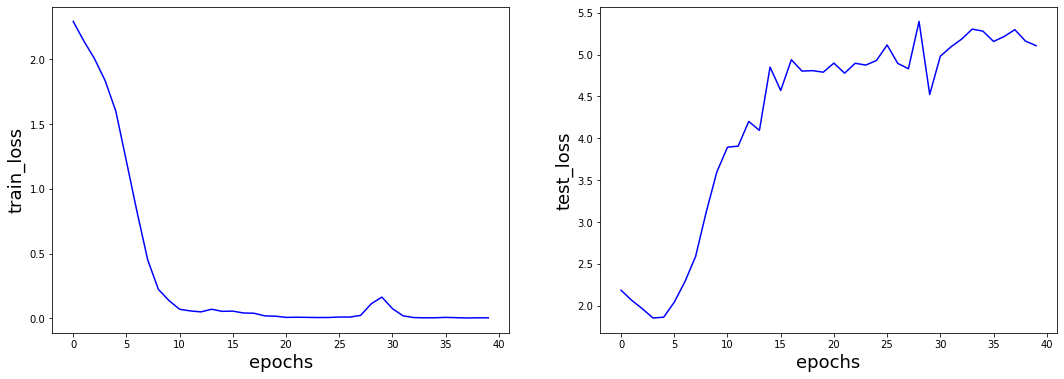

In [57]:
plot_his('accuracy', history)
plot_his('loss', history)